In [15]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import scipy as sp
import time


# JUST_ABOVE_ONE = 1.00000001 # np.random high arg is exclusive
JUST_ABOVE_ONE = np.nextafter(1.0, np.inf) # np.random high arg is exclusive
JUST_BELOW_ZERO = np.nextafter(0.0, -np.inf) # np.random low arg is inclusive
JUST_ABOVE_ONE_HALF = np.nextafter(0.5, np.inf) # np.random high arg is exclusive

In [16]:
def isotropic_direction_distribution(number_of_particles=1):
    distribution = np.cos(np.pi * np.random.uniform(low=0, high=JUST_ABOVE_ONE, size=number_of_particles))
    if number_of_particles == 1:
        return distribution[0]
    return distribution

def half_isotropic_direction_distribution(number_of_particles=1):
    """Returns a random direction in the half space defined by the given direction"""
    distribution = np.cos(np.pi * np.random.uniform(low=0, high=JUST_ABOVE_ONE_HALF, size=number_of_particles))
    if number_of_particles == 1:
        return distribution[0]
    return distribution

class Surface:
    def __init__(self, id, location):
        self.id = id
        self.location = location
        
        self.number_of_particles_passing_pos = 0
        self.number_of_particles_passing_neg = 0
        
    def pos_particle_pass(self):
        self.number_of_particles_passing_pos += 1
        
    def neg_particle_pass(self):
        self.number_of_particles_passing_neg += 1

class Material:
    def __init__(self, sigma_total=1, sigma_scatter=0):
        self.sigma_total = sigma_total
        self.sigma_scatter = sigma_scatter
        self.sigma_absorb = sigma_total - sigma_scatter
        
    def interaction_type(self):
        return np.random.choice(
            ["scatter", "absorb"],
            p=[self.sigma_scatter/self.sigma_total, self.sigma_absorb/self.sigma_total]
        )


class Cell:
    def __init__(self, id, width, material: Material, left_surface : Surface, right_surface : Surface):
        self.id = id
        self.width = width
        self.material = material
        self.left_surface = left_surface
        self.right_surface = right_surface
        
        self.neutron_histories = 0
        self.interaction_tally = 0
        self.absorption_tally = 0
        self.scattering_tally = 0
        self.track_length_tally = 0   
        
    def add_neutron_history(self):
        self.neutron_histories += 1
        
    def scatter(self, weight=1):
        self.scattering_tally += abs(weight)
        self.interaction_tally += abs(weight)
        
    def absorb(self, weight=1):
        self.absorption_tally += abs(weight)
        self.interaction_tally += abs(weight)
        
    def add_track_length(self, track_length, weight=1):
        self.add_neutron_history()
        self.track_length_tally += abs(track_length*weight)


class Mesh:
    def __init__(self, lengths : list[float], materials : list[Material], dx):

        for length in lengths:
            assert length / dx == int(length / dx), "length must be divisible by dx"
        self.lengths = lengths
        self.cell_width = dx
        self.problem_width = sum(lengths)
        self.num_cells = int(self.problem_width / dx)
        self.num_surfaces = self.num_cells + 1
        
        self.surfaces = [Surface(i, i * self.cell_width) for i in range(self.num_surfaces)]        
        index = 0
        self.cells = []
        for length, material in zip(lengths, materials):
            for i in range(int(length / dx)):
                self.cells.append(Cell(index, self.cell_width, material, self.surfaces[index], self.surfaces[index+1]))
                index += 1
        
    def get_cell(self, position):
        cell_id = int(position / self.cell_width) # floor
        if cell_id == self.num_cells:
            return self.cells[-1]
        return self.cells[cell_id]
    
    def get_surface_x_positions(self):
        return np.array([surface.location for surface in self.surfaces])
    
    def get_cell_x_positions(self):
        half_width = self.cell_width / 2
        return np.array([cell.left_surface.location + half_width for cell in self.cells])
    
    def get_absorption_tally(self):
        return np.array([cell.absorption_tally for cell in self.cells])
    
    def get_total_collision_tally(self):
        return np.array([cell.interaction_tally for cell in self.cells])
    
    def get_scalar_flux_collision_tally(self, number_of_particles):
        return np.array([cell.interaction_tally / cell.material.sigma_total / cell.width for cell in self.cells]) / number_of_particles
        # return np.array([cell.interaction_tally for cell in self.cells]) / number_of_particles
    
    def get_scalar_flux_track_length_tally(self, number_of_particles):
        return np.array([cell.track_length_tally / cell.width for cell in self.cells]) / number_of_particles
    
    def get_current_tally(self, number_of_particles):
        return np.array([surface.number_of_particles_passing_pos - surface.number_of_particles_passing_neg for surface in self.surfaces]) / number_of_particles
    

class Source:
    def __init__(self, number_of_particles):
        self.number_of_particles = number_of_particles
        
    def direction_distribution(self):
        raise NotImplementedError
    
    def location_distribution(self):
        raise NotImplementedError

class UniformSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0, direction=1):
        super().__init__(number_of_particles)
        self.location = location
        self.direction = direction
        
    def direction_distribution(self):
        return np.full(self.number_of_particles, self.direction)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)

class IsotropicVolumetricSource(Source):
    def __init__(self, number_of_particles, location_min=0, location_max=1):
        super().__init__(number_of_particles)
        self.location_min = location_min
        self.location_max = location_max

    def direction_distribution(self):
        return isotropic_direction_distribution(self.number_of_particles)

    def location_distribution(self):
        return np.random.uniform(low=self.location_min, high=self.location_max, size=self.number_of_particles)
    
class IsotropicSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0):
        super().__init__(number_of_particles)
        self.location = location
        
    def direction_distribution(self):
        return isotropic_direction_distribution(self.number_of_particles)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)
    
class HalfIsotropicSurfaceSource(Source):
    def __init__(self, number_of_particles, location=0):
        super().__init__(number_of_particles)
        self.location = location
        
    def direction_distribution(self):
        return half_isotropic_direction_distribution(self.number_of_particles)
    
    def location_distribution(self):
        return np.full(self.number_of_particles, self.location)


class MonteCarlo():
    def __init__(self, sources: list[Source], mesh : Mesh, left_boundary=None, right_boundary=None):
        """
        • A mesh to compute the spatial distribution of the scalar flux and
        reaction rates
        • A collision to compute the reaction rates then derive the scalar
        flux from it.
        • A surface tally to compute the current at the right and left sur-
        faces of the problem
        • A track-length tally to compute the scalar flux in every mesh
        cell.
        """
        self.sources : list[Source] = sources
        self.mesh : Mesh = mesh

        assert (
            left_boundary is None or left_boundary == "reflecting"
        ), "left_boundary must be none or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            right_boundary is None or right_boundary == "reflecting"
        ), "right_boundary must be none or 'reflecting'"
        self.right_boundary = right_boundary

        self.max_cell_transfers = 1000_000
        self.max_interactions = 1000_000

        self.particle_exits_left = 0
        self.particle_exits_right = 0

    def simulate_particle_to_interaction(self, position, direction):
        """Simulate a particle until it reaches an interaction or leaves the system

        Args:
            position (_type_): x location of the particle
            direction (_type_): cosine of the angle of the particle (positive is right, negative is left)
        """

        number_of_mean_free_paths_remaining = -np.log(np.random.uniform(low=0, high=JUST_ABOVE_ONE))        
        current_x_position = position
        current_cell = self.mesh.get_cell(current_x_position)
        
        for i in range(self.max_cell_transfers):
            if i == self.max_cell_transfers-1:
                raise Exception("Max cell transfers reached")

            distance_traveled_in_infinite_material = number_of_mean_free_paths_remaining / current_cell.material.sigma_total
            x_distance_traveled_in_infinite_material = distance_traveled_in_infinite_material * direction

            if direction >= 0:
                # greater than or equal since if it is zero its just not going to reach anyways
                next_surface = current_cell.right_surface
            elif direction < 0:
                next_surface = current_cell.left_surface

            x_distance_to_next_surface = next_surface.location - current_x_position

            if abs(x_distance_to_next_surface) < abs(x_distance_traveled_in_infinite_material):
                # Particle reaches the next surface before interacting with the material
                distanced_traveled_to_next_surface = x_distance_to_next_surface / direction
                # current_cell.add_track_length(distanced_traveled_to_next_surface)
                current_cell.add_track_length(abs(distanced_traveled_to_next_surface))

                number_of_mean_free_paths_remaining -= abs(distanced_traveled_to_next_surface) * current_cell.material.sigma_total
                assert number_of_mean_free_paths_remaining >= 0, "Number of mean free paths remaining cannot be negative"
                # current_x_position += x_distance_to_next_surface
                current_x_position = next_surface.location
                # particle has not had an interaction, so don't update angle

                if current_x_position <= 0:
                    # Particle leaves the system 
                    next_surface.neg_particle_pass()
                    if self.left_boundary == "reflecting":
                        direction = -direction
                        # current_x_position *= -1
                        continue
                    else:
                        break
                elif current_x_position >= self.mesh.problem_width:
                    # Particle leaves the system
                    next_surface.pos_particle_pass()
                    if self.right_boundary == "reflecting":
                        direction = -direction
                        # current_x_position = 2 * self.mesh.problem_width - current_x_position
                        continue
                    else:
                        break

                if direction > 0:
                    next_surface.pos_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id]
                elif direction < 0:
                    next_surface.neg_particle_pass()
                    current_cell = self.mesh.cells[next_surface.id - 1]
                else:
                    raise Exception("Direction cannot be zero with a particle reaching the next surface")
            else:
                # particle has an interaction in current cell
                current_cell.add_track_length(distance_traveled_in_infinite_material)
                current_x_position += x_distance_traveled_in_infinite_material
                break

        return current_x_position, current_cell

    def simulate_particle(self, initial_position, initial_direction):
        """Simulate a particle until it leaves the system or is absorbed"""    
        position = initial_position
        direction = initial_direction

        for i in range(self.max_interactions):
            if i == self.max_interactions-1:
                raise Exception("Max interactions reached")

            position, cell = self.simulate_particle_to_interaction(position, direction)

            if position <= 0:
                self.particle_exits_left += 1
                break
            elif position >= self.mesh.problem_width:
                self.particle_exits_right += 1
                break

            next_interaction = cell.material.interaction_type()
            if next_interaction == "scatter":
                # assuming isotropic scattering
                cell.scatter(weight=direction)
                direction = isotropic_direction_distribution()
                continue
            elif next_interaction == "absorb":
                cell.absorb(weight=direction)
                break
            else:
                raise Exception("Invalid interaction type")
            
            

    def simulate(self):
        """Simulate the transport of particles through the mesh and tally the results"""

        for source in self.sources:
            particle_locations = source.location_distribution()
            particle_directions = source.direction_distribution()

            # [self.simulate_particle(location, direction) for location, direction in zip(particle_locations, particle_directions)]
            for location, direction in zip(particle_locations, particle_directions):
                self.simulate_particle(location, direction)

            # with concurrent.futures.ThreadPoolExecutor() as executor:
            #     executor.map(self.simulate_particle, particle_locations, particle_directions)
            
                
    def plot_tallies(self):
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        x_positions = self.mesh.get_cell_x_positions()
        
        number_of_particles = sum([source.number_of_particles for source in self.sources])
        scalar_flux_collision_tally = self.mesh.get_scalar_flux_collision_tally(number_of_particles)
        scalar_flux_track_length_tally = self.mesh.get_scalar_flux_track_length_tally(number_of_particles)
        
        names = ["Collision", "Track Length"]
        for tally, name,ax, in zip([scalar_flux_collision_tally, scalar_flux_track_length_tally], names, axes):
            ax.plot(x_positions, tally, label=name)

            mean = np.mean(tally)
            std = np.std(tally)
            delta = 2 * std
            ax.fill_between(x_positions, tally - delta, tally + delta, alpha=0.2)

            ax.set_xlabel("Position (cm)")
            ax.set_title(f"{name} Tally")
            
        axes[0].set_ylabel("Scalar Flux Per CSA")
    
        return fig, ax

In [17]:
location = 0
problem_width=5
number_of_cells=100
dx = problem_width / number_of_cells
sigma_t = 1

def test_convergence(problem, particle_histories, name = "a", sigma_s_over_sigma_t_ratios=[0, 0.01, 0.99, 1]):
    orders_of_convergence = {}
    error_dict = {}
    for sigma_s_over_sigma_t_ratio in sigma_s_over_sigma_t_ratios:
        solutions = []
        for particle_history in particle_histories:
            solutions.append(
                problem(
                    number_of_particles=particle_history,
                    sigma_s_over_sigma_t=sigma_s_over_sigma_t_ratio,
                )
            )

        truth = solutions[-1]
        error = []
        for solution in solutions[:-1]:
            error.append(np.linalg.norm(solution - truth))

        error_dict[sigma_s_over_sigma_t_ratio] = error
        orders_of_convergence[sigma_s_over_sigma_t_ratio] = order_of_convergence(
            particle_histories[:-1], error
        )

    fig_sol, ax_sol = plt.subplots()
    for solution in solutions:
        ax_sol.plot(solution, label=f"{sigma_s_over_sigma_t_ratio}")

    ax_sol.legend()

    fig, ax = plt.subplots()
    for sigma_s_over_sigma_t_ratio, error in error_dict.items():
        ax.plot(particle_histories[:-1], error, label=f"{sigma_s_over_sigma_t_ratio} ({orders_of_convergence[sigma_s_over_sigma_t_ratio]:.2f})")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend(title=rf"$\frac{{\Sigma_s}}{{\Sigma_t}}$ (Conv. Order)")
    ax.set_xlabel("Number of Particles")
    ax.set_ylabel("Error")
    ax.set_title(f"2{name}) Monte Carlo")

    return fig_sol, ax_sol, fig, ax

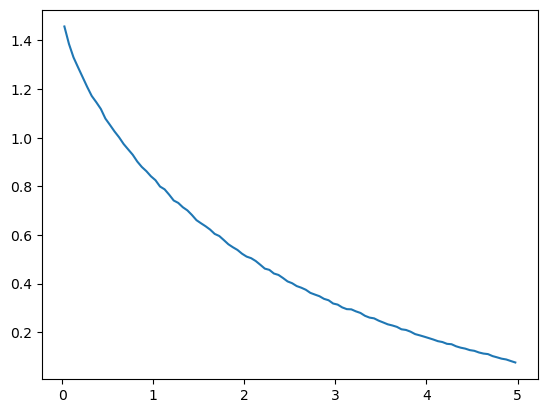

In [18]:
location = 0
problem_width=5
number_of_cells=100
dx = problem_width / number_of_cells
sigma_t = 1
sigma_s = 0.9
number_of_particles = 1_000_000

material = Material(sigma_total=sigma_t, sigma_scatter=sigma_s)
mesh = Mesh([problem_width], [material], dx)
volume_source = HalfIsotropicSurfaceSource(number_of_particles, location=0)
sim = MonteCarlo([volume_source], mesh)
sim.simulate()

# track_length_tally = sim.mesh.get_scalar_flux_track_length_tally(number_of_particles)
tally = sim.mesh.get_scalar_flux_collision_tally(number_of_particles)

fig, ax = plt.subplots()
ax.plot(mesh.get_cell_x_positions(), tally)

Text(0.5, 0, 'Position (cm)')

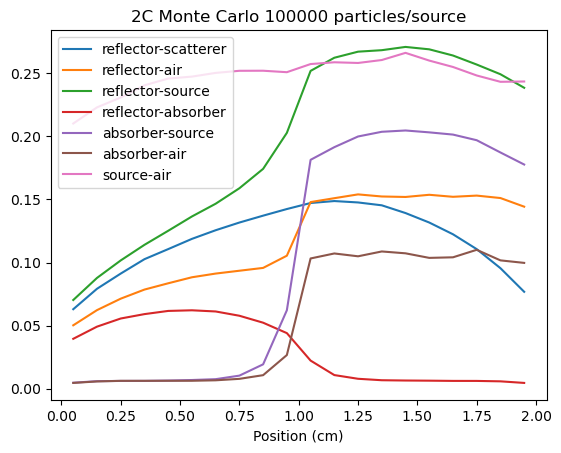

In [23]:
a_width = 1
b_width = 1
dx = 0.1

n_particles = 100_000
source = IsotropicVolumetricSource(
    n_particles, location_min=0, location_max=a_width + b_width
)

materials = {
    "reflector": {"sigma_total": 2, "sigma_scatter": 1.8},
    "scatterer": {"sigma_total": 2, "sigma_scatter": 1.99},
    "absorber": {"sigma_total": 10, "sigma_scatter": 2},
    "air": {"sigma_total": 0.01, "sigma_scatter": 0.006},
    "source": {"sigma_total": 0.1, "sigma_scatter": 0},
}

combos = [
    ["reflector", "scatterer"],
    ["reflector", "air"],
    ["reflector", "source"],
    ["reflector", "absorber"],
    ["absorber", "source"],
    ["absorber", "air"],
    ["source", "air"],
]

fig, ax = plt.subplots()
for combo in combos:
    material_a = Material(**materials[combo[0]])
    material_b = Material(**materials[combo[1]])
    mesh = Mesh([a_width, b_width], [material_a, material_b], dx)

    sources = [source]
    if combo[0] == "source":
        sources.append(
            IsotropicVolumetricSource(n_particles, location_min=0, location_max=a_width)
        )
    if combo[1] == "source":
        sources.append(
            IsotropicVolumetricSource(
                n_particles, location_min=a_width, location_max=a_width + b_width
            )
        )

    sim = MonteCarlo(sources, mesh)
    sim.simulate()
    track_length_tally = sim.mesh.get_scalar_flux_track_length_tally(number_of_particles)
    x_positions = mesh.get_cell_x_positions()
    ax.plot(x_positions, track_length_tally, label=f"{combo[0]}-{combo[1]}")

ax.legend()
ax.set_title(f"2C Monte Carlo {n_particles} particles/source")
ax.set_xlabel("Position (cm)")